<a href="https://colab.research.google.com/github/cryoTUD/ColabScale/blob/development/ColabScale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://gitlab.tudelft.nl/aj-lab/locscale/-/raw/master/doc/img/LocScale_logo.png" height="200" align="right" style="height:240px">

#ColabScale

Easy to use cryo-EM map optmisation using [`LocScale-2.0`](https://gitlab.tudelft.nl/aj-lab/locscale) including generation of confidence-weighted, feature-enhanced maps with [```LocScale-EMmerNet```](https://gitlab.tudelft.nl/aj-lab/emmernet).


See the `Locscale-2.0` <a href="https://cryotud.github.io/locscale/a">documentation</a> for more details, tutorials & troubleshooting, and/or read our <a href="#https://cryotud.github.io/locscale/about/#references">papers</a>.


In [1]:
# @title 1) Setup environment
#@markdown #### Please make sure to connect to a GPU runtime before starting.
#%%capture
import os
import sys
import random
from datetime import datetime
class HideStdout:
    def __init__(self, wait_message="Please wait", filepath=None):
        self._stdout = sys.stdout
        self.symbols = ['/', '-', '\\', '|']
        self.index = 0
        self.wait_message = wait_message
        self.old_stdout = None
        self.done_symbols = ['✅', '🎉', '🙌', '🚀']
        self.filepath = filepath

    def __enter__(self):
        self.old_stdout = sys.stdout
        self.old_stdout.flush()
        if self.filepath:
            self.file = open(self.filepath, 'a')
            sys.stdout = self
        else:
            sys.stdout = self

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self.old_stdout
        sys.stdout.write('\n')
        sys.stdout.flush()
        choose_done_symbol = random.choice(self.done_symbols)
        sys.stdout.write(choose_done_symbol + ' Done!\n')
        sys.stdout.flush()
        if self.filepath:
          self.file.close()

        if exc_type is not None:
            return False

    def write(self, content):
        self.old_stdout.write(f'\r{self.wait_message}... {self.symbols[self.index % len(self.symbols)]}')
        self.old_stdout.flush()
        self.index += 1
        if self.filepath:
          self.file.write(content)
          self.file.flush()

    def flush(self):
        if self.filepath:
          self.file.flush()
        pass

colabscale_output = "colabscale_output.txt"

time_installation_begin = datetime.now()
installation_start_time_string = time_installation_begin.strftime("%Y-%m-%d %H:%M:%S")
# Write a header to the output file
output_file = open(colabscale_output, 'a')
output_file.write("Welcome to ColabScale!\n")
output_file.write("Start installation at time {}".format(installation_start_time_string))
output_file.write("-"*50)
output_file.close()

import os
if not os.path.exists("LOCSCALE_READY"):
  with HideStdout("1/3 - 🔬 Installing LocScale 2.0", colabscale_output):
    !pip install git+https://github.com/cryoTUD/locscale.git@development
    !pip install stackview==0.8.0
  with HideStdout("2/3 - 🌐 Downloading models", colabscale_output):
    !locscale feature_enhance --download
  with HideStdout("3/3 - 💾 Downloading monomer library", colabscale_output):
    # install monomer library
    !mkdir /usr/local/monomer_lib
    !git clone https://github.com/MonomerLibrary/monomers.git /usr/local/monomer_lib
    !export CLIBD_MON=/usr/local/monomer_lib/

  !touch LOCSCALE_READY
  output_file = open(colabscale_output, 'a')
  time_installation_end = datetime.now()
  installation_end_time_string = time_installation_end.strftime("%Y-%m-%d %H:%M:%S")
  output_file.write("Installation completed at time {}".format(installation_end_time_string))
  output_file.write("Installation took {} minutes".format((time_installation_end - time_installation_begin).seconds/60))
  output_file.write("-"*50)
  output_file.close()
  os._exit(00)
else:
  print("You can now begin ColabScale!")
!export CLIBD_MON=/usr/local/monomer_lib/
os.environ["CLIBD_MON"] = "/usr/local/monomer_lib"
#@markdown ##### This kernel will automatically restart once it has finished running.
#@markdown __Re-run this cell to begin ColabScale.__

You can now begin ColabScale!


In [26]:
#@title 2) Get all imports
import os
import sys
import numpy as np
import gzip
from google.colab import files
from locscale.include.emmer.ndimage.map_tools import add_half_maps
from locscale.utils.file_tools import generate_filename_from_halfmap_path
from locscale.automate.tools import get_defaults_dictionary
import wget
proper_file_format = lambda x: x.endswith('.mrc') or x.endswith('.map') or x.endswith('.pdb') or x.endswith('.cif') or x.endswith('.mmcif')
from datetime import datetime
import threading
import warnings
warnings.filterwarnings('ignore')
import functools


class SimplifyOutput:
    # This class was written with the help of chatGPT, model: GPT4
    def __init__(self, filepath=None):
      self._stdout = sys.stdout
      self.show_progress = True
      self.symbols = ['/', '-', '\\', '|']
      self.index = 0
      self.wait_message = "Starting LocScale"
      self.old_stdout = None
      self.locscale_started = False
      self.stop_event = threading.Event()
      self.filepath = filepath
    def __enter__(self):
      self.old_stdout = sys.stdout
      self.old_stdout.flush()
      self.start_time = datetime.now()
      self.cursor_thread = threading.Thread(target=self.rotate_cursor)
      self.cursor_thread.start()
      if self.filepath:
        self.file = open(self.filepath, 'a')
        sys.stdout = self
      else:
        sys.stdout = self

    def __exit__(self, exc_type, exc_val, exc_tb):
      if self.filepath:
        self.file.close()

      self.stop_event.set()           # Signal the thread to stop
      self.cursor_thread.join()       # Wait for it to finish

      sys.stdout = self.old_stdout
      if self.show_progress:
          sys.stdout.write('\n')
          sys.stdout.flush()
          sys.stdout.write('Done!\n')
          sys.stdout.flush()
      if exc_type is not None:
          return False

    def rotate_cursor(self):
      while not self.stop_event.is_set():
        self.old_stdout.write(f'\r{self.wait_message}... {self.symbols[self.index % len(self.symbols)]}')
        self.old_stdout.flush()
        self.index += 1
        self.stop_event.wait(1)  # Wait for 1 second

    def write(self, content):
      lines_to_check_and_status = {
        "Preparing mask" : "😷 Preparing a mask",
        "Building Pseudo-atomic model" : "⚙️ Creating hybrid models (this may take a while)",
        "Running model refinement" : "⚛️ Refining Atomic Displacement Parameters (this may take a while)",
        "Simulating model-map using refined": "🗺️ Obtaining reference maps",
        "Loading input" : "🛠️ Preparing inputs",
        "Preparation completed. Now running LocScale": "💻 Running LocScale (this may take a while)"
      }

      lines_to_check = list(lines_to_check_and_status.keys())
      for line_to_check in lines_to_check:
        if line_to_check in content:
          self.wait_message = lines_to_check_and_status[line_to_check]

      if "Running MC-EMmerNet" in content or "Running EMmerNet" in content:
        self.wait_message = content.strip()

      if self.filepath:
        self.file.write(content)
        self.file.flush()


    def flush(self):
        pass

def get_half_maps_from_user():
  uploaded = files.upload()
  halfmap_paths = []
  assert len(uploaded) == 2, "Please select only two files..."
  for map in uploaded.keys():
    if proper_file_format(map):
      halfmap_paths.append(map)
    else:
      print("Uploaded file format is not either MRC or MAP; please select correct file...")
      os.remove(map)
      uploaded = files.upload()
      os.rename(map,map)
      halfmap_paths.append(map)

  return halfmap_paths


def get_full_map_from_user():
  uploaded = files.upload()
  assert len(uploaded) == 1, "Please select only one file..."
  for map in uploaded.keys():
    if proper_file_format(map):
      return map
    else:
      print("Uploaded file format is not either MRC or MAP; please select correct file...")
      os.remove(map)
      uploaded = files.upload()
      os.rename(map,map)
      return map

def get_model_from_user():
  uploaded = files.upload()
  assert len(uploaded) == 1, "Please select only one file..."
  for model in uploaded.keys():
    if model.endswith('.pdb'):
      return model
    else:
      print("Uploaded file is not a PDB file; please select correct file...")
      os.remove(model)
      uploaded = files.upload()
      os.rename(model,model)
      return model

def uncompress_if_needed(file_path):
  """Uncompresses the file at the given path if it is compressed."""
  if file_path.endswith('.gz'):
    uncompressed_path = file_path[:-3]
    with gzip.open(file_path, 'rb') as f_in:
      with open(uncompressed_path, 'wb') as f_out:
        f_out.write(f_in.read())
    print(f"Uncompressed {file_path} to {uncompressed_path}")
    return uncompressed_path
  return file_path


def project_map(emmap, projection_axis, projection_type="mean"):
    """
    Project the map along a given axis
    """
    if projection_type == "mean":
        fun = np.nanmean
    elif projection_type == "max":
        fun = np.nanmax
    elif projection_type == "min":
        fun = np.nanmin
    else:
        raise ValueError(f"Unknown projection type {projection_type}")

    if projection_axis == "x":

        return fun(emmap, axis=2)
    elif projection_axis == "y":
        return fun(emmap, axis=1)
    elif projection_axis == "z":
        return fun(emmap, axis=0)
    else:
        raise ValueError(f"Projection axis {projection_axis} is not valid. Choose from x, y, z")

def plot_projections(emmap, cmap="viridis", show_colorbar=False, projection_type="mean", return_figure=False, title=None):
    """
    Plot the projections of the map
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig, axes = plt.subplots(1, 3, figsize=(6, 18), dpi=300)

    projection_in_x = project_map(emmap, "x",projection_type)
    im_x=axes[0].imshow(projection_in_x, cmap=cmap)
    axes[0].set_title("X")
    # show axis colorbar
    if show_colorbar:
        divider = make_axes_locatable(axes[0])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im_x, cax=cax, orientation="vertical", cmap=cmap)

    projection_in_y = project_map(emmap, "y",projection_type)
    im_y=axes[1].imshow(projection_in_y, cmap=cmap)
    axes[1].set_title("Y")
    # show axis colorbar
    if show_colorbar:
        divider = make_axes_locatable(axes[1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im_y, cax=cax, orientation="vertical", cmap=cmap)
        # hide y axis ticks
        axes[1].set_yticks([])

    axes[0].set_yticks([])

    projection_in_z = project_map(emmap, "z",projection_type)
    im_z=axes[2].imshow(projection_in_z, cmap=cmap)
    axes[2].set_title("Z")
    # show colorbar
    if show_colorbar:
        divider = make_axes_locatable(axes[2])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im_z, cax=cax, orientation="vertical", cmap=cmap)
        # hide y axis ticks
        axes[2].set_yticks([])

    axes[0].set_yticks([])
    axes[1].set_yticks([])
    axes[2].set_yticks([])
    axes[0].set_xticks([])
    axes[1].set_xticks([])
    axes[2].set_xticks([])

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    if return_figure:
        return fig
    else:
        plt.show()



In [4]:
#@title ### 3) Prepare ColabScale job
job_name = 'test' #@param {type:"string"}

In [5]:
#@title ####  3a) Define data input type
my_own_data = False #@param {type:"boolean"}
example_from_emdb = True #@param {type:"boolean"}

assert my_own_data or example_from_emdb, "Please select at least one option..."
if my_own_data and example_from_emdb:
  print("You've selected both 'My own data' and 'Example from EMDB'.\nTo avoid conflicts, we'll prioritize using your own data.\nIf you prefer to use the EMDB example, please uncheck the 'My own data' option.")
  example_from_emdb = False


In [ ]:
#@title #### 3b) Use own data
#@markdown ##### Run this code cell to upload your half maps. The maps will be deleted after runtime.
if my_own_data:
  use_full_map_instead = False #@param {type:"boolean"}
  if not use_full_map_instead:
    halfmap_paths = []
    half_maps = {}
    half_maps_directory = os.path.join(job_name, f"half_maps")
    os.makedirs(half_maps_directory, exist_ok=True)
    print("Please select half maps...")
    halfmap_paths_raw = get_half_maps_from_user()
    for map in halfmap_paths_raw:
      new_map_path = os.path.join(half_maps_directory, map)
      os.rename(map,new_map_path)
      halfmap_paths.append(new_map_path)

  else:
    raw_input_map_path = get_full_map_from_user()
    input_map_path = os.path.join(job_name, os.path.basename(raw_input_map_path))
    os.rename(raw_input_map_path, input_map_path)

  filter_my_halfmaps = False #@param {type:"boolean"}
  if use_full_map_instead and filter_my_halfmaps:
    print("Filtering inputs only possible with half-maps.\nSince you have chosen to upload full map as input, the filter_my_halfmaps option will be ignored")

  apply_fsc_filter = filter_my_halfmaps if not use_full_map_instead else False

  # Example usage for half maps:
  if not use_full_map_instead:
    input_half_map_path_1 = halfmap_paths[0]
    input_half_map_path_2 = halfmap_paths[1]
    input_half_map_path_1 = uncompress_if_needed(input_half_map_path_1)
    input_half_map_path_2 = uncompress_if_needed(input_half_map_path_2)
    emmap_path_filename = generate_filename_from_halfmap_path(input_half_map_path_1)
    emmap_path = add_half_maps(input_half_map_path_1, input_half_map_path_2, emmap_path_filename, fsc_filter=apply_fsc_filter)
  else:
    input_map_path = uncompress_if_needed(input_map_path)
    emmap_path = input_map_path

In [6]:
#@title #### 3c) Example from EMDB
#@markdown ##### Choose EMDB ID
emdb_id = "3061" #@param {type:"string"}
if example_from_emdb:
  halfmap_path_1_url = f"https://files.wwpdb.org/pub/emdb/structures/EMD-{emdb_id}/other/	emd_{emdb_id}_half_map_1.map.gz"
  halfmap_path_2_url = f"https://files.wwpdb.org/pub/emdb/structures/EMD-{emdb_id}/other/	emd_{emdb_id}_half_map_2.map.gz"

  half_maps_directory = os.path.join(job_name)
  os.makedirs(half_maps_directory, exist_ok=True)
  # Download the half-maps
  halfmap_path_1 = os.path.join(half_maps_directory, f"emd_{emdb_id}_half_map_1.map.gz")
  halfmap_path_2 = os.path.join(half_maps_directory, f"emd_{emdb_id}_half_map_2.map.gz")
  wget.download(halfmap_path_1_url, halfmap_path_1)
  wget.download(halfmap_path_2_url, halfmap_path_2)
  #with HideStdout("Downloading half-maps"):
    # Uncompress the half-maps
  halfmap_path_1 = uncompress_if_needed(halfmap_path_1)
  halfmap_path_2 = uncompress_if_needed(halfmap_path_2)
  emmap_path_filename = generate_filename_from_halfmap_path(halfmap_path_1)
  emmap_path = add_half_maps(halfmap_path_1, halfmap_path_2, emmap_path_filename, fsc_filter=False)

Uncompressed test/emd_3061_half_map_1.map.gz to test/emd_3061_half_map_1.map
Uncompressed test/emd_3061_half_map_2.map.gz to test/emd_3061_half_map_2.map
Saving as MRC file format with following properties: 
File name:  test/EMD_3061_unsharpened_fullmap.mrc
Voxel size (1.4, 1.4, 1.4)
Origin (0., 0., 0.)
Shape (180, 180, 180)


In [7]:
#@title 4) Choose job type
job_type = "model-free" # @param ["model-based", "model-free", "hybrid", "feature_enhance"]
#@markdown - __model-based__: ```LocScale``` sharpening using atomic model
#@markdown - __model-free__: ```LocScale``` sharpening without atomic model
#@markdown - __hybrid__: ```LocScale``` sharpening with partial atomic model
#@markdown - __feature_enhance__: Confidence-aware density modification with ```LocScale-EMmerNet```

locscale_inputs = {}
default_dictionary_query = "feature_enhance" if job_type == "feature_enhance" else "locscale"
locscale_inputs = get_defaults_dictionary(default_dictionary_query)

locscale_inputs["emmap_path"] = emmap_path
locscale_inputs["complete_model"] = True if job_type == "hybrid" else False



In [ ]:
#@title 5) Other input files
#@markdown ##### Run this code cells to upload other files.
locscale_inputs = {}

#@markdown ##### 1) Upload atomic models (Required for model based or hybrid locscale)
use_atomic_model = False #@param {type:"boolean"}
#@markdown ###### or
use_pdb_id = "" #@param {type:"string"}
if use_atomic_model:
  raw_model_input_path = get_model_from_user()
  input_model_path = os.path.join(job_name, raw_model_input_path)
  os.rename(raw_model_input_path, input_model_path)
elif use_pdb_id:
  input_model_path = os.path.join(job_name, f"{use_pdb_id}.pdb")
  wget.download(f"https://files.rcsb.org/download/{use_pdb_id}.pdb", input_model_path)
else:
  input_model_path = None

#@markdown ##### 2) Upload your own mask (optional)

use_mask = False #@param {type:"boolean"}
if use_mask:
   raw_mask_input = get_full_map_from_user()
   input_mask_path = os.path.join(job_name, os.path.basename(raw_mask_input))
   os.rename(raw_mask_input, input_mask_path)
else:
   input_mask_path = None


locscale_inputs["mask"] = input_mask_path
locscale_inputs["model_coordinates"] = input_model_path


In [8]:
#@title 6) Relevant options

#model_resolution = None #@param {type:"string"}
symmetry = "C1" #@param {type:"string"}

#@markdown - Specifies point group for map symmetrisation. Supported groups are C<sub>n</sub>, D<sub>n</sub>, T, O, I
#@markdown - Helical symmetry is not yet supported

output_name = "my_optimised_map.mrc" #@param {type:"string"}
#@markdown - Base string for output file names
#@markdown - `None` will use __`job_name`__
locscale_inputs["outfile"] = output_name
locscale_inputs["symmetry"] = symmetry


In [9]:
#@title 7) Advanced Options

from google.colab import files
import os
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

#@markdown Most of these options should be left at default. Please only change if necessary and if you know what you are doing.

#@markdown #### FDR options

fdr_threshold = 0.01 #@param {type:"string"}
fdr_window_size = None #@param {type:"string"}
fdr_filter = None #@param {type:"string"}
averaging_filter_size = 3 #@param {type:"string"}
mask_threshold = 0.99 #@param {type:"string"}

locscale_inputs["fdr_threshold"] = fdr_threshold
locscale_inputs["fdr_window_size"] = fdr_window_size
locscale_inputs["fdr_filter"] = fdr_filter
locscale_inputs["averaging_filter_size"] = averaging_filter_size
locscale_inputs["mask_threshold"] = mask_threshold

#@markdown #### Pseudomodel options
pseudomodel_iterations = "20" #@param {type:"string"}

#@markdown #### Refinement options
refinement_iterations = "10" #@param {type:"string"}


#@markdown \

#@markdown #### EMmerNet options
low_context_model = False #@param {type:"boolean"}
batch_size = "48" #@param {type:"string"}
stride = 16 #@param {type:"string"}
gpu_ids = "0" #@param {type:"string"}
gpu_ids = [str(gpu_id) for gpu_id in gpu_ids.split(',')]
locscale_inputs["use_low_context_model"] = low_context_model
locscale_inputs["batch_size"] = int(batch_size)
locscale_inputs["gpu_ids"] = gpu_ids
locscale_inputs["stride"] = int(stride)

#@markdown \

#@markdown #### Reference options

model_resolution = None #@param {type:"string"}

#@markdown \

#@markdown #### Processing options
num_cpus = os.cpu_count()
number_processes = "max_cpu"  #@param {type:"string"}
verbose = True #@param {type:"boolean"}

if number_processes == "max_cpu":
  number_processes = num_cpus
elif int(number_processes) > num_cpus:
  number_processes = num_cpus

print(number_processes)

locscale_inputs["number_processes"] = int(number_processes)
locscale_inputs["verbose"] = verbose
locscale_inputs["model_resolution"] = model_resolution
locscale_inputs["total_iterations"] = int(pseudomodel_iterations)
locscale_inputs["refmac_iterations"] = int(refinement_iterations)

2


In [ ]:
#@title 7) Run LocScale
from locscale.utils.startup_utils import launch_locscale_no_mpi, launch_feature_enhance_no_mpi
import argparse
args = argparse.Namespace()
args.__dict__.update(locscale_inputs)

locscale_output = SimplifyOutput(filepath=colabscale_output)
with locscale_output:
  if job_type == "feature_enhance":
    launch_feature_enhance_no_mpi(args)
  else:
    launch_locscale_no_mpi(args)


In [37]:
#@title 8) Analyse results
#@markdown ### Display scaled and unscaled maps

#!pip install stackview==0.8.0
import stackview
import ipywidgets as widgets
from google.colab import output
output.enable_custom_widget_manager()
from ipywidgets import HBox, VBox
from locscale.include.emmer.ndimage.map_utils import load_map
#import pyclesperanto_prototype as cle

#cle.select_device("cupy")


export = True #@param {type:"boolean"}
#@markdown - export output as PNG images
input_colormap = "gray" #@param ['gray','plasma', 'viridis', 'inferno']
locscale_colormap = "inferno" #@param ['gray','plasma', 'viridis', 'inferno']
#@markdown - `gray`: greyscale
#@markdown - Other options are [perceptually uniform sequential color maps](https://matplotlib.org/stable/users/explain/colors/colormaps.html#sequential)
zoom_factor = 1 # @param {type:"number"}
display_style = "curtain" #@param {type:"string"}['curtain','stacked', 'toggle']

# load data
input_map, apix = load_map(emmap_path)
output_map_path = os.path.join(os.path.dirname(emmap_path), locscale_inputs["outfile"])
scaled_map = load_map(output_map_path)[0]

# set scale
input_map = input_map/input_map.max()*255
scaled_map = scaled_map/scaled_map.max()*255

# set style & arrange widgets
if display_style == "curtain":
  print("Input map (left) vs. LocScale map (right)\n")
  w1 = stackview.curtain(input_map,scaled_map, zoom_factor=zoom_factor, axis=0, colormap=input_colormap, curtain_colormap=locscale_colormap)
  w2 = stackview.curtain(input_map,scaled_map, zoom_factor=zoom_factor, axis=1, colormap=input_colormap, curtain_colormap=locscale_colormap)
  w3 = stackview.curtain(input_map,scaled_map, zoom_factor=zoom_factor, axis=2, colormap=input_colormap, curtain_colormap=locscale_colormap)
  plot_map = HBox([w1, w2, w3])
elif display_style == "stacked":
  print("Input map (top) vs. LocScale map (bottom)\n")
  w1 = stackview.orthogonal(input_map,zoom_factor=zoom_factor, colormap=input_colormap)
  w2 = stackview.orthogonal(scaled_map,zoom_factor=zoom_factor, colormap=locscale_colormap)
  plot_map = VBox([w1, w2])
elif display_style == "toggle":
   print("Use buttons to toggle between maps")
   plot_map = stackview.switch(
     {"Input":    input_map,
     "LocScale": scaled_map,
     },
     colormap=[input_colormap, locscale_colormap],
     toggleable=True)
plot_map

FileNotFoundError: [Errno 2] No such file or directory: 'test/EMD_3061_unsharpened_fullmap.mrc'

In [2]:
#@title 9) Segment detergent micelle with LocScale-SURFER
#@markdown #### Toggle membrane visualisation with LocScale-SURFER
from locscale.utils.prepare_inputs import prepare_mask_from_inputs
from locscale.include.emmer.ndimage.map_utils import load_map, save_as_mrc
predict_membrane = True #@param{type:"boolean"}

if predict_membrane:
  if not os.path.exists("LOCSCALE_SURFER_READY"):
    with HideStdout("🏄 Installing LocScale-SURFER", colabscale_output):
      !pip install torch==2.2.2+cpu torchvision==0.17.2+cpu timm==0.9.16 -f https://download.pytorch.org/whl/torch_stable.html
      !git clone https://github.com/cryoTUD/locscale-surfer.git

      # import segmentation models
      !mv locscale-surfer locscalesurfer
      !rm -rf locscalesurfer/src/__init__.py
      !touch LOCSCALE_SURFER_READY


🏄 Installing LocScale-SURFER... /
🙌 Done!


In [13]:
emmap_path


'test/EMD_3061_unsharpened_fullmap.mrc'

In [17]:
from locscalesurfer.src.surfer import predict
from locscale.preprocessing.headers import run_FDR

model_state_path="/content/locscalesurfer/src/data/SURFER_SCUNet.pt"
emmap_path_full = os.path.abspath(os.path.basename(emmap_path))
emmap, apix = load_map(emmap_path_full)
fdr_inputs_dict = {
        "emmap_path" : emmap_path_full,
        "window_size" : int(emmap.shape[0]*0.1),
        "fdr" : 0.01,
        "filter_cutoff" : 5,
        "averaging_filter_size" : 3,
    }

with HideStdout("😷 Preparing mask", colabscale_output):
  mask_path, mask_path_raw = run_FDR(**fdr_inputs_dict)
  mask = load_map(mask_path)[0]
with HideStdout("🍩 Segmenting detergent micelle", colabscale_output):
  predicted_micelle = predict(emmap, apix, mask, model_state_path=model_state_path)

save_as_mrc(predicted_micelle, os.path.join(os.path.dirname(emmap_path_full), "predicted_micelle.mrc"))


😷 Preparing mask... |
✅ Done!
🍩 Segmenting detergent micelle... -
✅ Done!


FileNotFoundError: [Errno 2] No such file or directory: 'test/predicted_micelle.mrc'

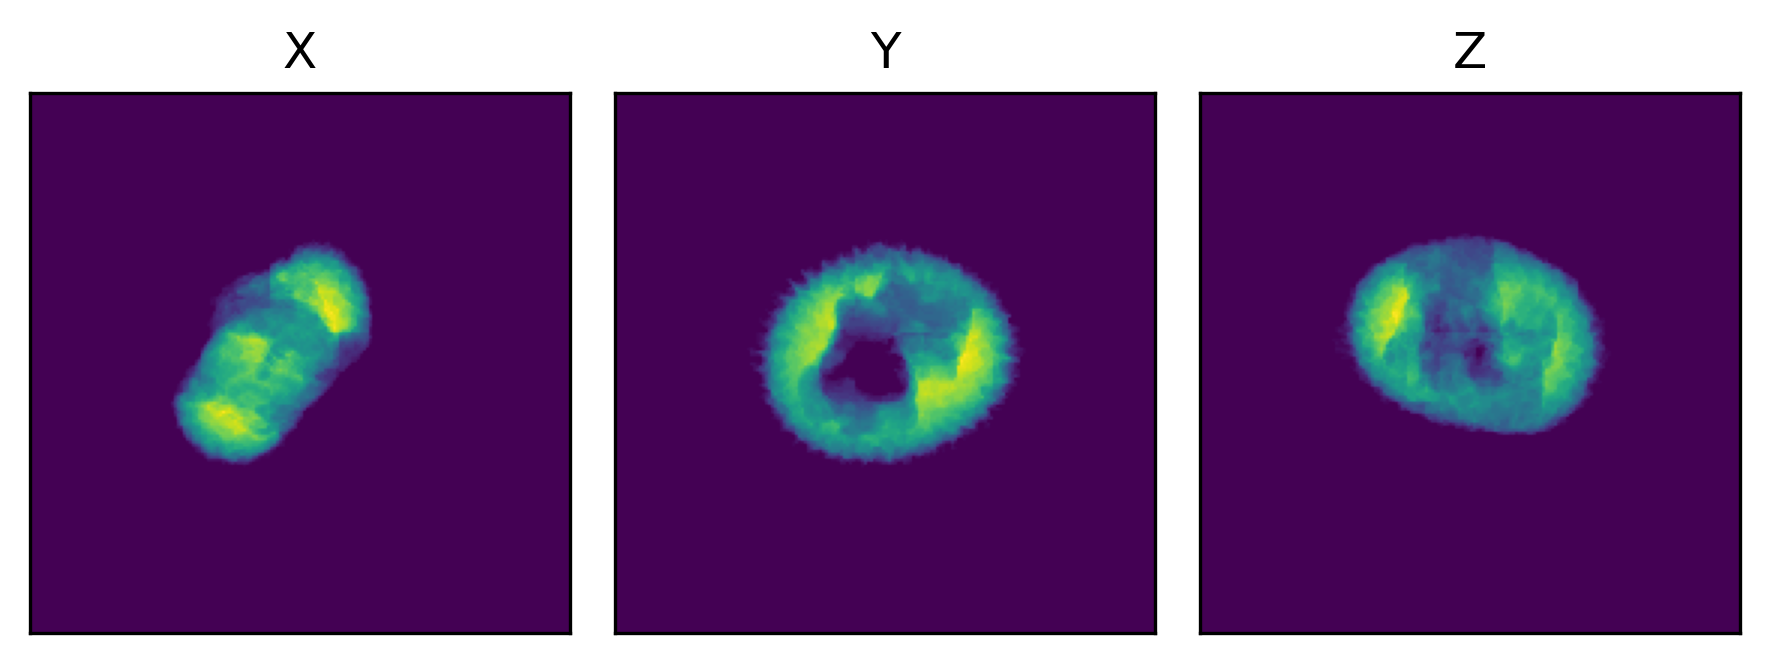

In [42]:
#@title View predictions

prediction_threshold = 0.5 # @param {"type":"slider","min":0,"max":1,"step":0.05}
predicted_micelle_binary = (predicted_micelle > prediction_threshold).astype(int)
plot_projections(predicted_micelle_binary)

In [46]:
#@title Toggle membrane visualisation

target_map_path = '/content/test/EMD_3061_unsharpened_fullmap.mrc'#@param{type: "string"}
target_map, apix = load_map(target_map_path)
# remove micelle and plot the output
predicted_micelle_binary_inverse = 1 - predicted_micelle_binary
target_map_with_micelle_removed = target_map * predicted_micelle_binary_inverse

input_colormap = "plasma" #@param ['gray','plasma', 'viridis', 'inferno']
locscale_colormap = "inferno" #@param ['gray','plasma', 'viridis', 'inferno']
#@markdown - `gray`: greyscale
#@markdown - Other options are [perceptually uniform sequential color maps](https://matplotlib.org/stable/users/explain/colors/colormaps.html#sequential)
zoom_factor = 1 # @param {type:"number"}
display_style = "toggle" #@param {type:"string"}['curtain','stacked', 'toggle']

# load data
# set scale
target_map_rescaled = target_map/target_map.max()*255
target_map_with_micelle_removed_rescaled = target_map_with_micelle_removed/target_map_with_micelle_removed.max()*255

# set style & arrange widgets
if display_style == "curtain":
  print("With detergent micelle (left) vs. Without detergent micelle (right)\n")
  w1 = stackview.curtain(target_map_rescaled,target_map_with_micelle_removed_rescaled, zoom_factor=zoom_factor, axis=0, colormap=input_colormap, curtain_colormap=locscale_colormap)
  w2 = stackview.curtain(target_map_rescaled,target_map_with_micelle_removed_rescaled, zoom_factor=zoom_factor, axis=1, colormap=input_colormap, curtain_colormap=locscale_colormap)
  w3 = stackview.curtain(target_map_rescaled,target_map_with_micelle_removed_rescaled, zoom_factor=zoom_factor, axis=2, colormap=input_colormap, curtain_colormap=locscale_colormap)
  plot_map = HBox([w1, w2, w3])
elif display_style == "stacked":
  print("With detergent micelle (top) vs. Without detergent micelle (bottom)\n")
  w1 = stackview.orthogonal(target_map_rescaled,zoom_factor=zoom_factor, colormap=input_colormap)
  w2 = stackview.orthogonal(target_map_with_micelle_removed_rescaled,zoom_factor=zoom_factor, colormap=locscale_colormap)
  plot_map = VBox([w1, w2])
elif display_style == "toggle":
   print("Use buttons to toggle between maps")
   plot_map = stackview.switch(
     {"With micelle":    target_map_rescaled,
     "Without micelle": target_map_with_micelle_removed_rescaled,
     },
     colormap=[input_colormap, locscale_colormap],
     toggleable=True)
plot_map


Use buttons to toggle between maps


In [ ]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\".
import shutil
from google.colab import drive

# compress
download_files = True #@param {type:"boolean"}
if download_files:
  shutil.make_archive(job_name, 'zip', job_name)
  files.download(f"{job_name}.zip")

save_to_google_drive = False #@param {type:"boolean"}
if save_to_google_drive == True and drive:
  drive.mount('/content/drive')
  !cp -r {job_name} '/content/drive/MyDrive'
  print(f"Uploaded {job_name}.zip to Google Drive with ID {uploaded.get('id')}")

